# ZFOURGE Bolometric Luminosity Functions

### Import and setup

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(8, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN3.csv')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN3.csv')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN3.csv')
df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
print(f'Number of sources: {len(df)}')

# Use Mask
df = df[df['Use'] == 1]
print(f'Number of sources Use=1: {len(df)}')

# LIR Mask
df = df[df['LIR'] > 0]
print(f'Number of sources LIR>0: {len(df)}')

# F24 Mask
df = df[df['F24'] > 0]
print(f'Number of sources F24>0: {len(df)}')

# Redshift Mask
z_mask = (df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])
df = df[z_mask]
print(f'Number of sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(df)}')

# AGN Mask
AGN_mask = (df['irAGN'] == 1) | (df['radAGN'] == 1) | (df['xAGN'] == 1)
df = df[~AGN_mask]
print(f'Number of sources AGN=0: {len(df)}')

Number of sources: 73790
Number of sources Use=1: 37647
Number of sources LIR>0: 22997
Number of sources F24>0: 22997
Number of sources 0.0 <= z <= 6.0: 22967
Number of sources AGN=0: 22444


### Quiescent vs Starforming

Quiescent: 1502
Star-forming: 20942


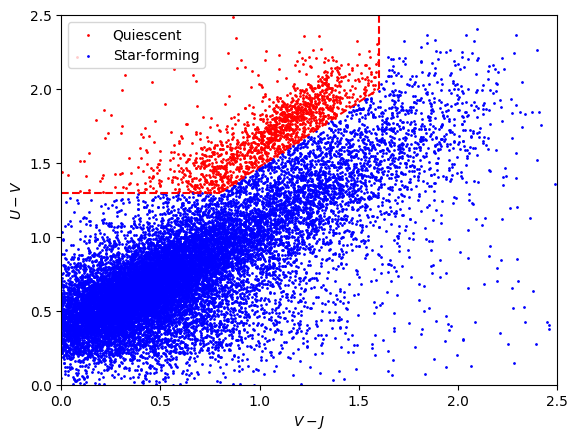

In [49]:
U_ab = 25 - 2.5*np.log10(df['FU']) # apparent magnitude -> AB magnitude
V_ab = 25 - 2.5*np.log10(df['FV']) # apparent magnitude -> AB magnitude
J_ab = 25 - 2.5*np.log10(df['FJ']) # apparent magnitude -> AB magnitude

U_V = U_ab - V_ab
V_J = V_ab - J_ab

mask_q = (U_V > 1.3) & (V_J < 1.6) & (U_V > 0.88*V_J+0.59)
print(f'Quiescent: {mask_q.sum()}')
print(f'Star-forming: {len(U_V) - mask_q.sum()}')

df = df[mask_q] # 1,502 - quiescent
# df = df[~mask_q] # 20,942 - star-forming

plt.scatter(V_J[mask_q], U_V[mask_q], s=1, label='Quiescent', color='red')
plt.scatter(V_J[~mask_q], U_V[~mask_q], s=1, label='Star-forming', color='blue')
plt.xlabel('$V - J$')
plt.ylabel('$U - V$')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.hlines(1.3, 0, 0.8, colors='red', linestyles='dashed')
plt.vlines(1.6, 2, 2.5, colors='red', linestyles='dashed')
plt.plot([0.8, 1.6], [1.3, 2.0], color='red', linestyle='dashed')
plt.legend()
plt.show()

### Luminosity Distribution & Bolometric Flux Limit

[3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18, 3.71487913262542e-18]


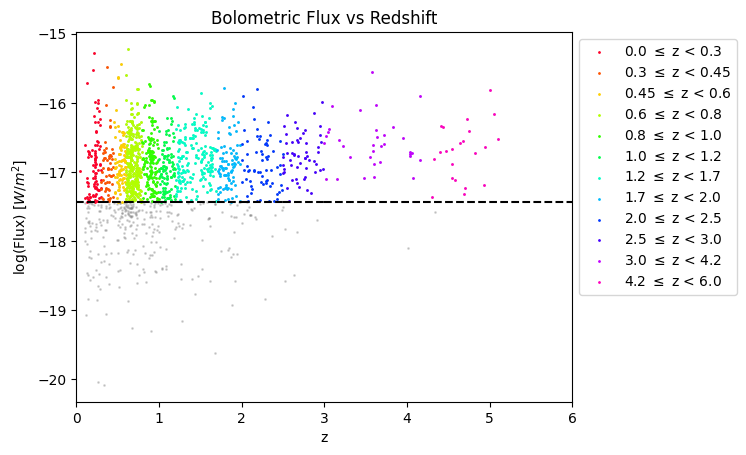

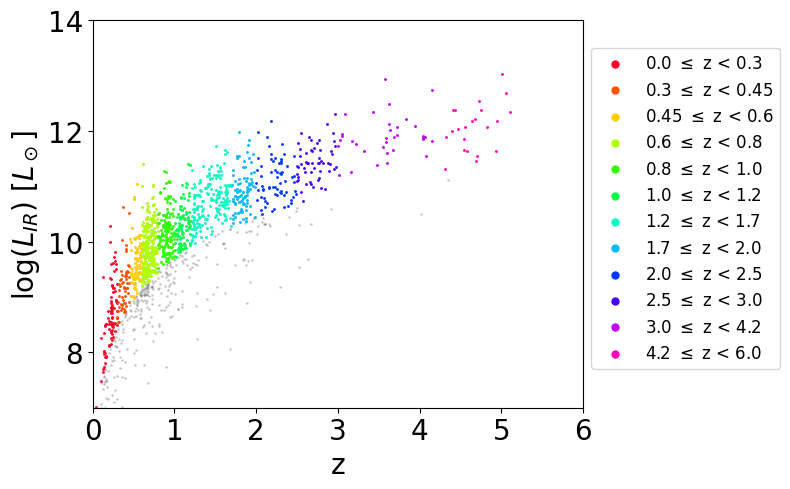

Number of sources: 1201


In [50]:
luminosity = df['LIR'].copy().values # solar luminosities
luminosity *= 3.828 * 10 ** 26 # solar luminosity -> Watts
z = df['zpk'].values # redshift

# Plot Colours
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))

# Luminsity distance of galaxies
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

# Bolometric Flux completeness limits
F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2
plt.scatter(z, np.log10(F_bol), s=1, color='grey', alpha=0.3)
Fbol_lims = []
for (z_start, z_end), c in zip(redshift_bins, colors):
    mask_z = (z >= z_start) & (z < z_end)
    # F_lim = np.percentile(F_bol[mask_z], 100-F_comp) # % of the data above perc
    F_lim = np.percentile(F_bol, 100-F_comp) # % of the data above perc
    # F_lim = 3.882 * 10 ** -18 # W/m^2
    Fbol_lims.append(F_lim)
    mask_f = F_bol > F_lim
    plt.scatter(z[mask_z & mask_f], np.log10(F_bol[mask_z & mask_f]), s=1, label=f'{z_start} $\leq$ z < {z_end}', color=c)
    plt.hlines(np.log10(F_lim), z_start, z_end, color='black', linestyle='--')
print(Fbol_lims)
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log(Flux) [$W/m^2$]')
plt.xlabel('z')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

total = 0
z_corr = []
lum_corr = []
fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(z, np.log10(luminosity/(3.83*10**26)), s=1, color='grey', alpha=0.3)
for (z_start, z_end), Fbol_lim, c in zip(redshift_bins, Fbol_lims, colors):
    mask_z = (z >= z_start) & (z < z_end)
    mask_fbol = F_bol > Fbol_lim
    plt.scatter(z[mask_z & mask_fbol], np.log10(luminosity[mask_z & mask_fbol]/(3.83*10**26)), s=1, label=f'{z_start} $\leq$ z < {z_end}', color=c)
    total += np.sum(mask_z & mask_fbol)
    z_corr.append(z[mask_z & mask_fbol])
    lum_corr.append(np.log10(luminosity[mask_z & mask_fbol]/(3.83*10**26)))
# plt.title('Bolometric Luminosity vs Redshift')
plt.ylabel('log($L_{IR}$) [$L_\odot$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.ylim(7, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.xticks([0,1,2,3,4,5,6])
plt.tick_params(axis='both', labelsize=20)
plt.legend(bbox_to_anchor=(1, 0.95), fontsize=12, markerscale=5)
plt.tight_layout()
# plt.savefig('LIR_vs_z_ZF.png', dpi=300)
plt.show()
print(f'Number of sources: {total}')

# np.savez('LIR_vs_z_ZF', 
#     z_corr=np.array(z_corr, dtype=object),
#     lum_corr=np.array(lum_corr, dtype=object),
#     z=np.array(z, dtype=object),
#     lum=np.array(np.log10(luminosity/(3.83*10**26)), dtype=object),
#     z_bins=np.array(redshift_bins, dtype=object))


### Calculate Maximum Volume

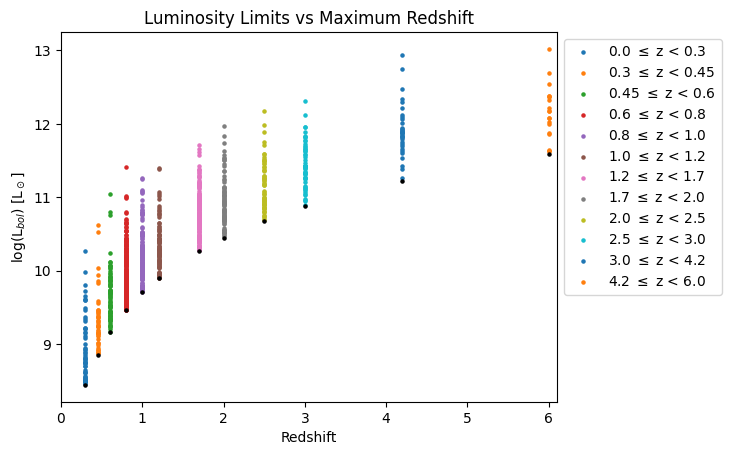

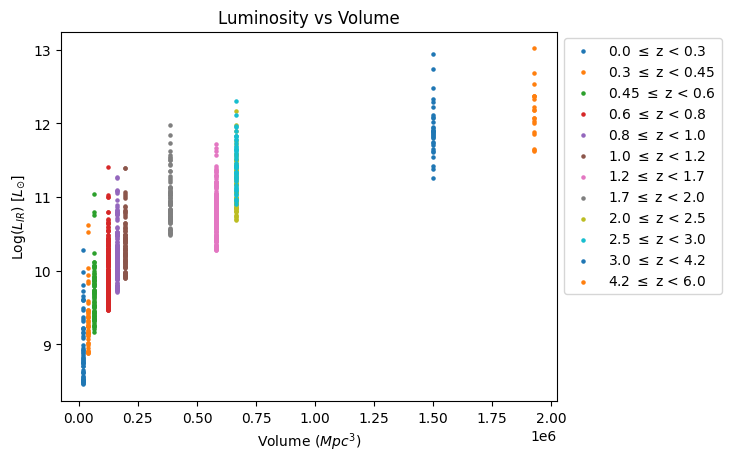

In [51]:
def lum_lim(z, f_lim):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # W

all_data = []
zmaxs = []
L_lims = []

for (z_start, z_end), Fbol_lim in zip(redshift_bins, Fbol_lims):
    mask_z = (z >= z_start) & (z < z_end)
    mask_fbol = F_bol > Fbol_lim
    
    # Source lumiosity must be greater than the minimum luminosity (from luminosity distance)
    l_lim = lum_lim(z_end, Fbol_lim)
    mask_l = luminosity > l_lim
    
    # Luminosity of galaxies in each redshift bin
    lum_bin = np.log10(luminosity[mask_z & mask_fbol & mask_l]/(3.83*10**26))
    
    # Minimum and maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmax = cosmo.comoving_distance(z_end).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask_z & mask_fbol & mask_l] / (4*np.pi*Fbol_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
        
    # Limit the maximum galaxy distance to the end of the redshift bin
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Find the maximum redshift of each source
    zmax_bin = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    
    # Data
    all_data.append([vol, lum_bin])
    zmaxs.append(zmax_bin)
    L_lims.append(l_lim)
    
    # Plot
    plt.scatter(zmax_bin, lum_bin, s=5, label=f'{z_start} $\leq$ z < {z_end}')
    plt.scatter(z_end, np.log10(l_lim/(3.83*10**26)), s=5, color='black')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(L$_{bol}$) [L$_\odot$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+0.1)
plt.show()

for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Volume')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Counts Histograms

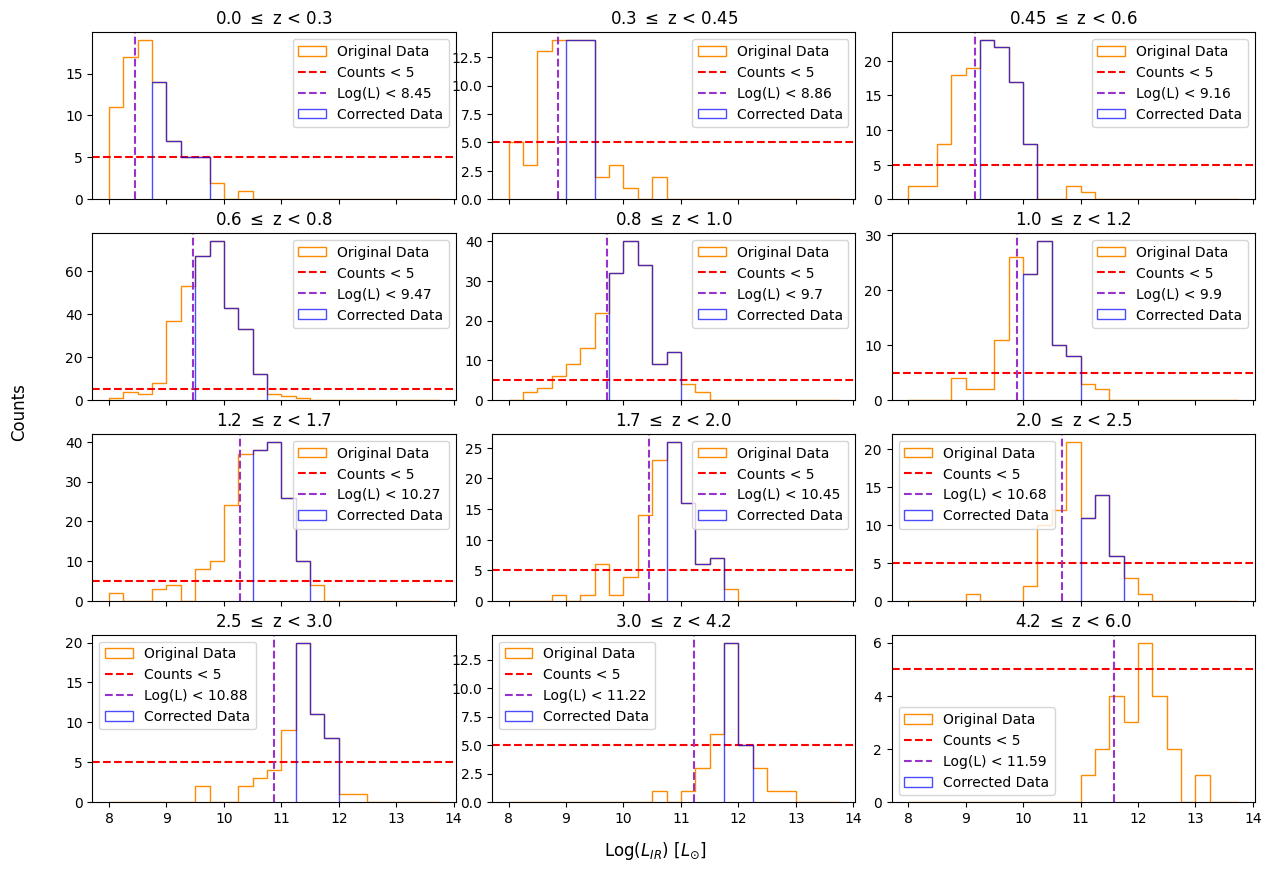

0.0 <= z < 0.3
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 8.45


0.3 <= z < 0.45
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 8.86


0.45 <= z < 0.6
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 9.16


0.6 <= z < 0.8
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 9.47


0.8 <= z < 1.0
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 9.7


1.0 <= z < 1.2
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 9.9


1.2 <= z < 1.7
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 10.27


1.7 <= z < 2.0
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 10.45


2.0 <= z < 2.5
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 10.68


2.5 <= z < 3.0
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Completeness: 10.88


3.0 <= z < 4.2
Bolometric Flux Completeness: 3.71e-18 W/m^2
Luminosity Compl

In [52]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
bin_edges = []
for ax, (z_start, z_end), (vol, lum), min_l in zip(axes.flatten(), redshift_bins, all_data, L_lims):
    mask_z = (z > z_start) & (z <= z_end)
    mask_l = luminosity > min_l
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append([])
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

for min_l, (z_start, z_end), Fbol_lim in zip(L_lims, redshift_bins, Fbol_lims):
    print(f'{z_start} <= z < {z_end}')
    print(f'Bolometric Flux Completeness: {Fbol_lim:.2e} W/m^2')
    print(f'Luminosity Completeness: {np.round(np.log10(min_l/(3.83*10**26)), 2)}')
    print('\n')

### Luminosity Function

0.0 <= z < 0.3
[8.875, 9.125, 9.375, 9.625]
[-2.54 -2.84 -2.98 -2.98]
[0.12 0.16 0.19 0.19]


0.3 <= z < 0.45
[9.125, 9.375]
[-2.84 -2.84]
[0.12 0.12]


0.45 <= z < 0.6
[9.375, 9.625, 9.875, 10.125]
[-2.84 -2.86 -2.97 -3.3 ]
[0.09 0.09 0.11 0.15]


0.6 <= z < 0.8
[9.625, 9.875, 10.125, 10.375, 10.625]
[-2.66 -2.62 -2.86 -2.97 -3.41]
[0.05 0.05 0.07 0.08 0.13]


0.8 <= z < 1.0
[9.875, 10.125, 10.375, 10.625, 10.875]
[-3.1  -3.01 -3.08 -3.65 -3.53]
[0.08 0.07 0.07 0.14 0.13]


1.0 <= z < 1.2
[10.125, 10.375, 10.625, 10.875]
[-3.33 -3.22 -3.69 -3.78]
[0.09 0.08 0.14 0.15]


1.2 <= z < 1.7
[10.625, 10.875, 11.125, 11.375]
[-3.58 -3.56 -3.75 -4.16]
[0.07 0.07 0.09 0.14]


1.7 <= z < 2.0
[10.875, 11.125, 11.375, 11.625]
[-3.57 -3.78 -4.21 -4.14]
[0.09 0.11 0.18 0.16]


2.0 <= z < 2.5
[11.125, 11.375, 11.625]
[-4.18 -4.07 -4.44]
[0.13 0.12 0.18]


2.5 <= z < 3.0
[11.375, 11.625, 11.875]
[-3.92 -4.18 -4.32]
[0.1  0.13 0.15]


3.0 <= z < 4.2
[11.875, 12.125]
[-4.43 -4.88]
[0.12 0.19]




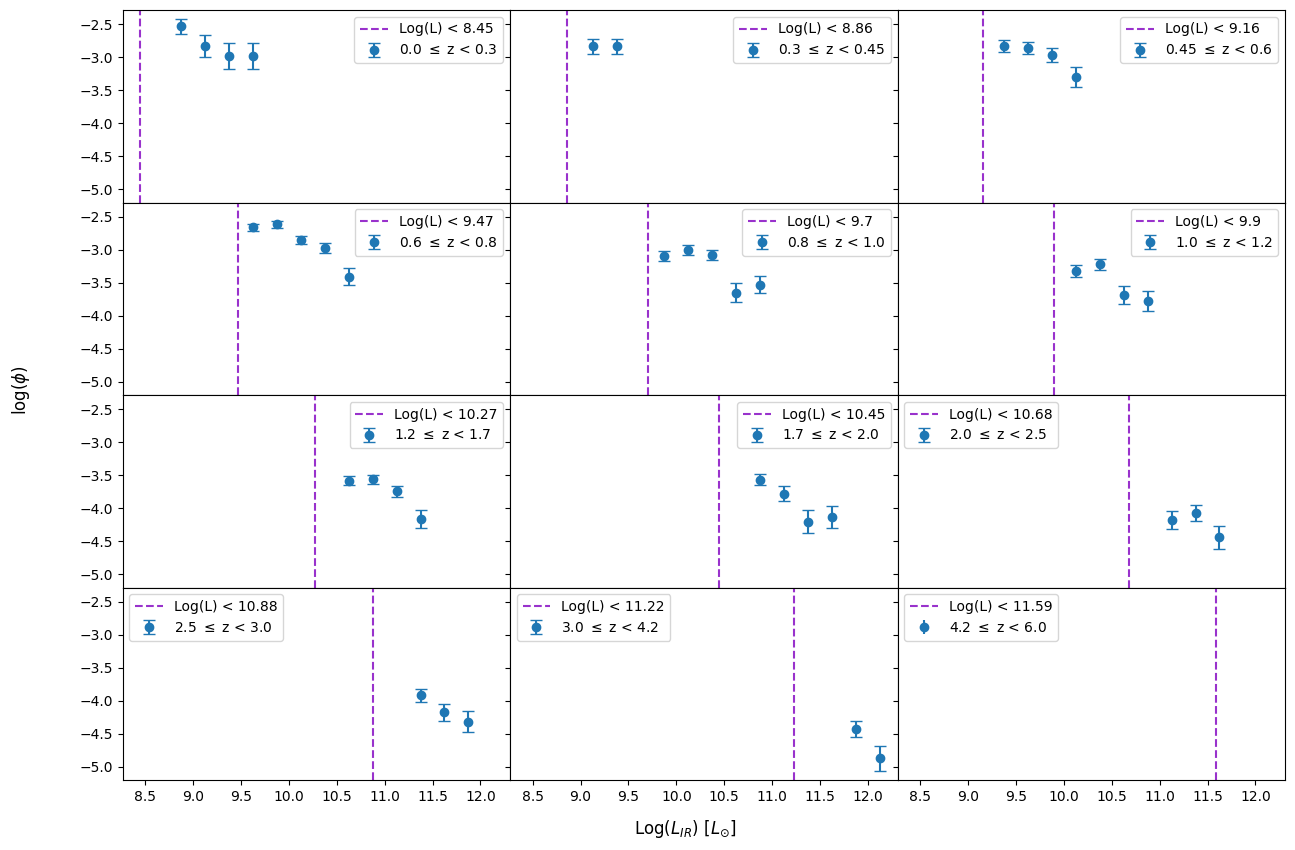

In [53]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    try:
        delta_log_l = np.diff(bin)[0]
    except IndexError:
        lum_centers.append([])
        phi.append([])
        phi_e.append([])
        continue
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), L_lims):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.legend()

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

for (z_start, z_end), lum_centers_z, phi_z, phi_e_z in zip(redshift_bins, lum_centers, phi, phi_e):
    if len(lum_centers_z) == 0:
        continue
    print(f'{z_start} <= z < {z_end}')
    print(lum_centers_z)
    print(np.round(np.log10(phi_z),2))
    print(np.round(np.array(phi_e_z) / (np.array(phi_z) * np.log(10)),2))
    print('\n')

### Schechter Fit

0.0 <= z < 0.3 Function fit:
Log L_star = 9.51 +/- 0.27
Log phi_star = -2.61 +/- 0.27
Alpha = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 9.68 +/- inf
Log phi_star = -2.77 +/- inf
Alpha = 1.2


0.45 <= z < 0.6 Function fit:
Log L_star = 10.28 +/- 0.2
Log phi_star = -2.93 +/- 0.2
Alpha = 1.2


0.6 <= z < 0.8 Function fit:
Log L_star = 10.55 +/- 0.18
Log phi_star = -2.74 +/- 0.18
Alpha = 1.2


0.8 <= z < 1.0 Function fit:
Log L_star = 10.9 +/- 0.37
Log phi_star = -3.18 +/- 0.37
Alpha = 1.2


1.0 <= z < 1.2 Function fit:
Log L_star = 10.85 +/- 0.39
Log phi_star = -3.32 +/- 0.39
Alpha = 1.2


1.2 <= z < 1.7 Function fit:
Log L_star = 11.41 +/- 0.0
Log phi_star = -3.62 +/- 0.0
Alpha = 1.2


1.7 <= z < 2.0 Function fit:
Log L_star = 10.76 +/- 0.33
Log phi_star = -2.91 +/- 0.33
Alpha = 1.2


2.0 <= z < 2.5 Function fit:
Log L_star = 10.93 +/- 0.95
Log phi_star = -3.23 +/- 0.95
Alpha = 1.2


2.5 <= z < 3.0 Function fit:
Log L_star = 11.19 +/- 0.52
Log phi_star = -3.14 +/- 0.52
Alpha = 1.2

C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1522724750.py:42: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1522724750.py:44: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *(params+perr))),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1522724750.py:45: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1522724750.py:2: RuntimeWarning: divide by zero encountered in power
  return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)


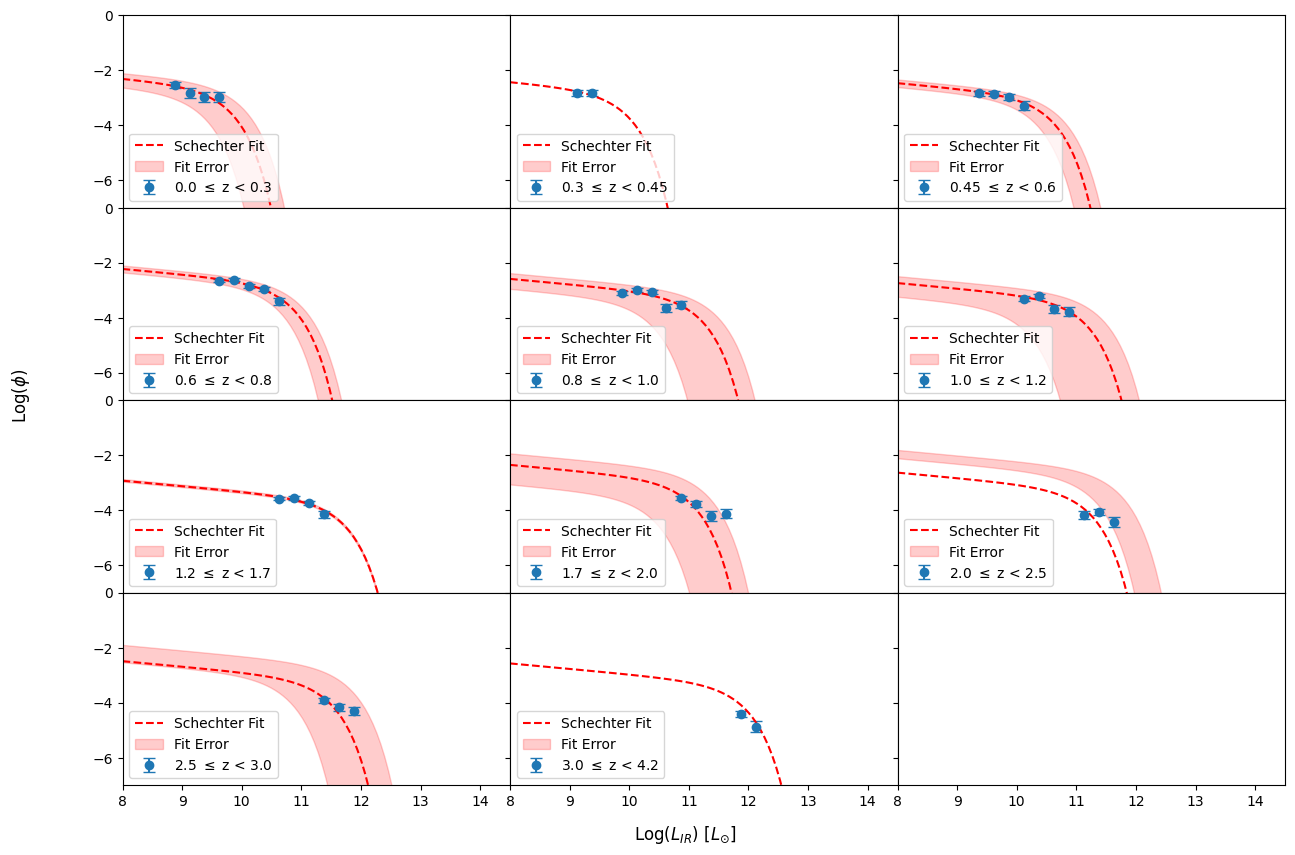

In [57]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        schecter_params.append(params)
        schecter_errors.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue

    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Alpha = 1.2')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *(params+perr))),
        np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

0.0 <= z < 0.3 Function fit:
Log L_star = 8.57 +/- 0.85
Log phi_star = -2.48 +/- 0.41
Alpha = 1.3
Sigma = 1.1


0.3 <= z < 0.45 Function fit:
Log L_star = 9.68 +/- inf
Log phi_star = -2.97 +/- inf
Alpha = 1.3
Sigma = 1.0


0.45 <= z < 0.6 Function fit:
Log L_star = 9.42 +/- 0.43
Log phi_star = -2.8 +/- 0.19
Alpha = 1.3
Sigma = 0.9


0.6 <= z < 0.8 Function fit:
Log L_star = 9.71 +/- 0.34
Log phi_star = -2.61 +/- 0.16
Alpha = 1.3
Sigma = 0.8


0.8 <= z < 1.0 Function fit:
Log L_star = 10.23 +/- 0.58
Log phi_star = -3.1 +/- 0.26
Alpha = 1.3
Sigma = 0.7


1.0 <= z < 1.2 Function fit:
Log L_star = 10.13 +/- 0.63
Log phi_star = -3.22 +/- 0.35
Alpha = 1.3
Sigma = 0.7


1.2 <= z < 1.7 Function fit:
Log L_star = 10.49 +/- 0.39
Log phi_star = -3.39 +/- 0.24
Alpha = 1.3
Sigma = 0.7


1.7 <= z < 2.0 Function fit:
Log L_star = 10.67 +/- 0.35
Log phi_star = -3.47 +/- 0.23
Alpha = 1.3
Sigma = 0.7


2.0 <= z < 2.5 Function fit:
Log L_star = 10.89 +/- 0.0
Log phi_star = -3.82 +/- 0.13
Alpha = 1.3
Sigm

C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\3931535146.py:2: RuntimeWarning: divide by zero encountered in power
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)


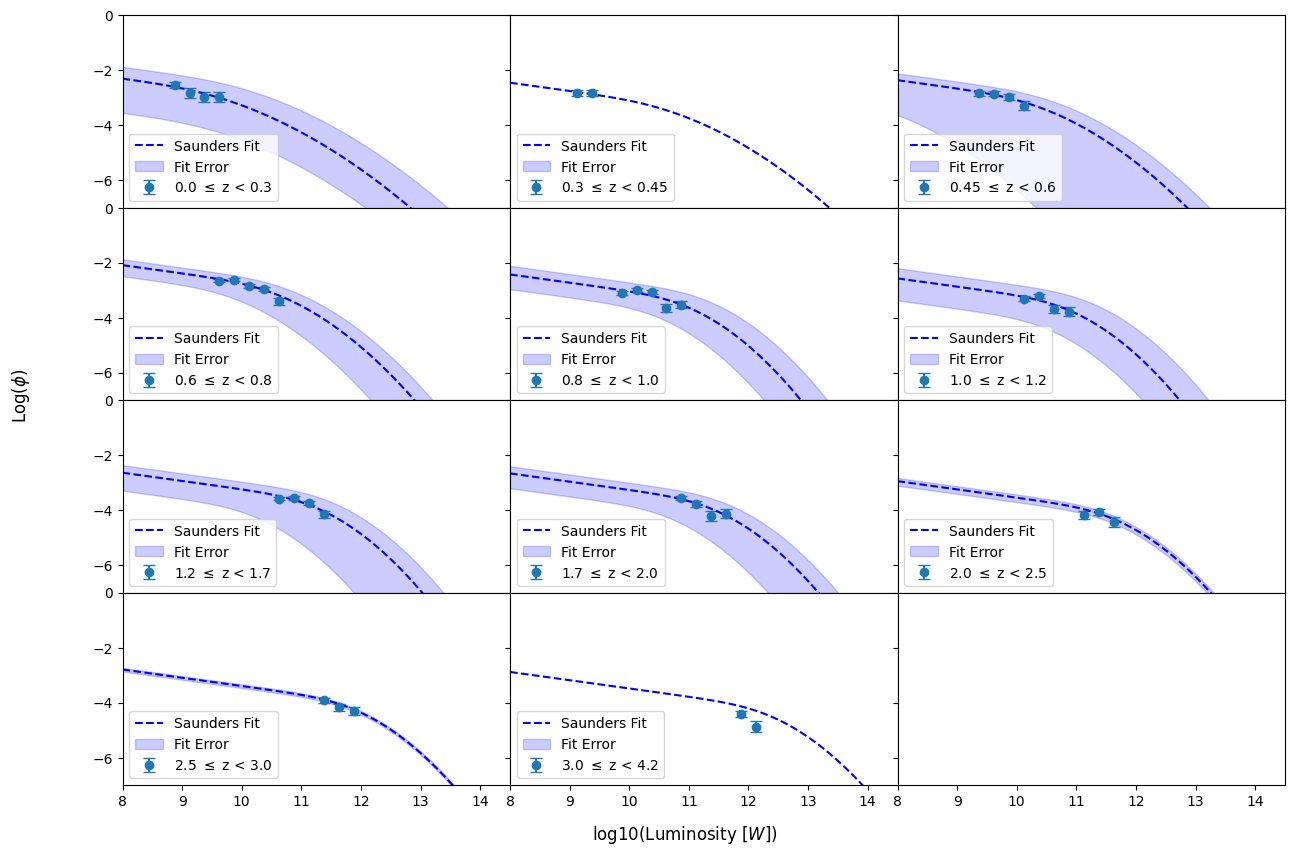

In [55]:
def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
sigmas = [1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, sigma in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), sigmas):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        saunder_params.append(params)
        saunder_error.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}.')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[1]) / (params[1] * np.log(10)),2)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = {sigma}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *(params+perr), sigma)), 
        np.log10(saunders_luminosity(long_lum, *np.abs(params-perr), sigma)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter & Saunders

C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1299286192.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1299286192.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1299286192.py:13: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_up)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\1522724750.py:2: RuntimeWarning: divide by zero encountered in power
  return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)


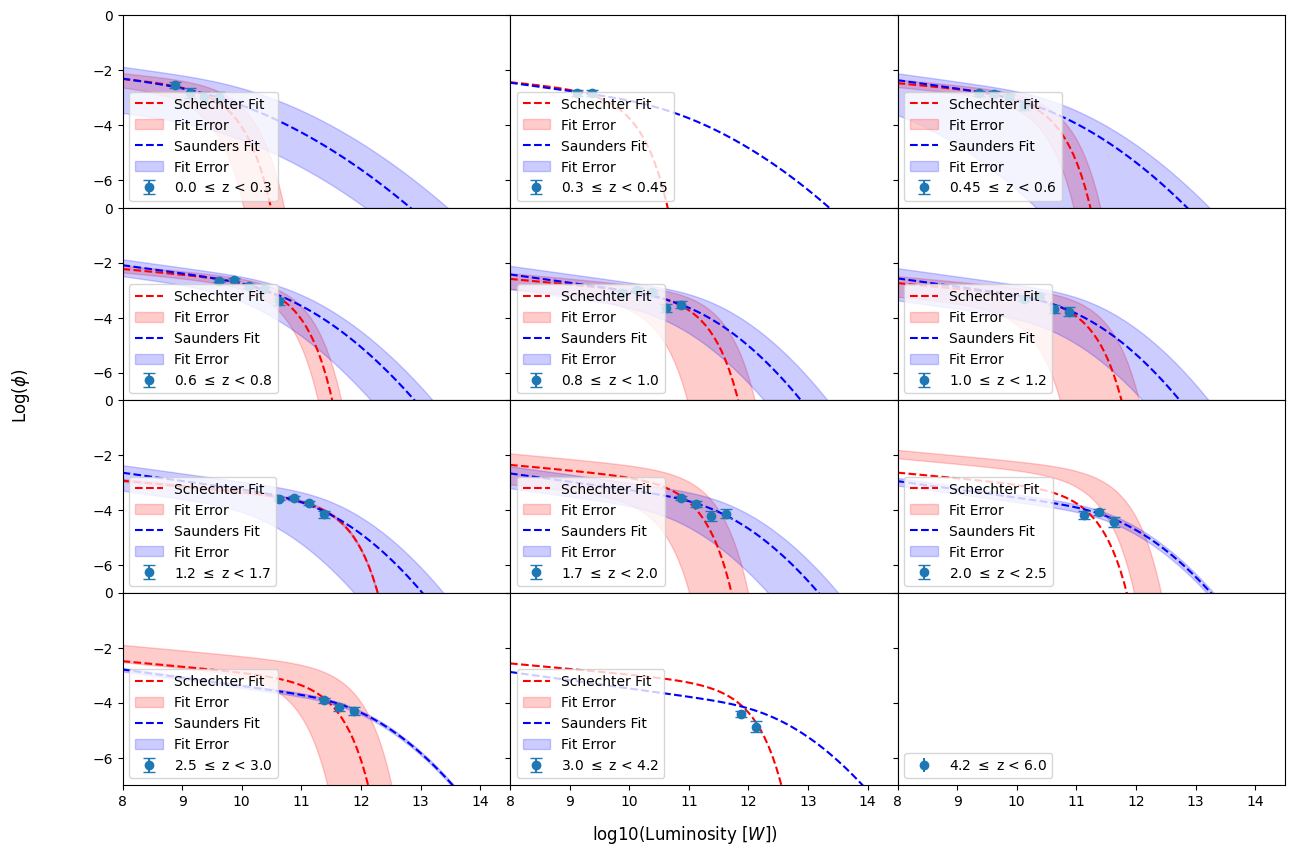

In [60]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for ax, params, perr in zip(axes.flatten(), schecter_params, schecter_errors):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')

# Saunders Function
for ax, params, perr, sigma in zip(axes.flatten(), saunder_params, saunder_error, sigmas):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(saunders_luminosity(long_lum, *p_down, sigma)),
        np.log10(saunders_luminosity(long_lum, *p_up, sigma)),
        color='blue', alpha=0.2, label='Fit Error')

# Luminosity Function
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))        
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

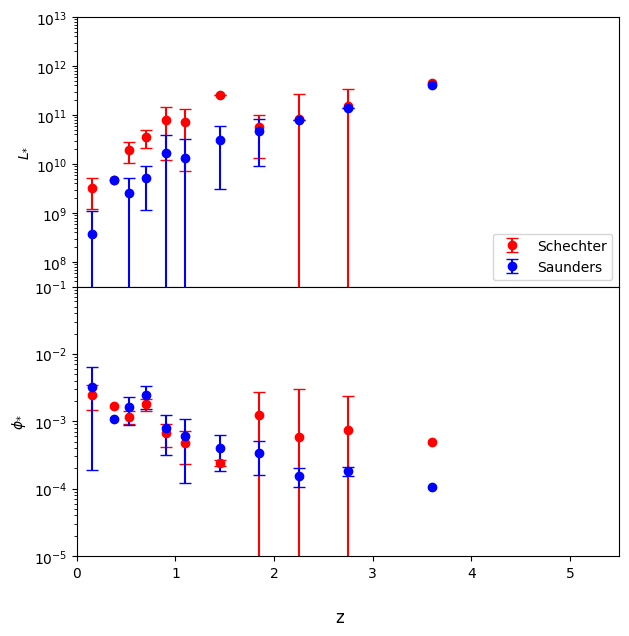

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_ylim(10**7.5, 10**13)
ax[1].set_ylim(10**-5, 10**-1)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

### Class Evolution

C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\3931535146.py:2: RuntimeWarning: invalid value encountered in scalar power
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\3931535146.py:2: RuntimeWarning: divide by zero encountered in scalar power
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)
C:\Users\n10480129\AppData\Local\Temp\ipykernel_14676\3931535146.py:2: RuntimeWarning: invalid value encountered in log10
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)


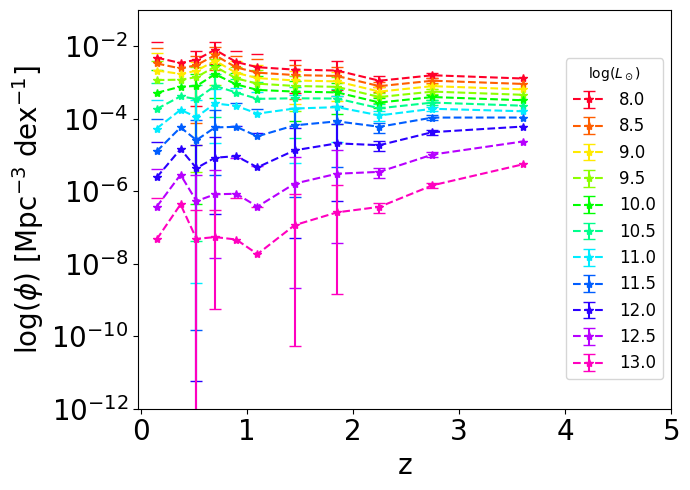

In [62]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_classes = np.arange(8, 13.5, 0.5)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(7, 5))

def custom_log_formatter(val, pos):
    # Convert the logarithmic value to an exponent
    exponent = int(np.log10(val))
    return f'${exponent}$'

class_phi = []
for lum in luminosity_classes:
    lum_phi = []
    for params, perr, sigma in zip(saunder_params, saunder_error, sigmas):
    # for params, perr in zip(schecter_params, schecter_errors):
        if len(params) == 0:
            lum_phi.append([np.nan, np.nan, np.nan])
            continue
        phis = saunders_luminosity(10**lum, *params, sigma)
        phi_up = saunders_luminosity(10**lum, *(params+perr), sigma)
        phi_down = saunders_luminosity(10**lum, *(params-perr), sigma)
        # phis = schechter_luminosity(10**lum, *params)
        # phi_up = schechter_luminosity(10**lum, *(params+perr))
        # phi_down = schechter_luminosity(10**lum, *(params-perr))
        lum_phi.append([phis, phi_up-phis, phis-phi_down])
    class_phi.append(lum_phi)

for lum, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    phis = class_lum[:,0]
    phi_up = class_lum[:,1]
    phi_down = class_lum[:,2]
    plt.errorbar(redshift_centers, phis, yerr=[phi_down, phi_up], ls='--', capsize=4, marker='*', label=f'{lum}', color=c)
    
plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.yscale('log')
# plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.xticks([0,1,2,3,4,5])
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.ylim(10**-12, 10**-1)
plt.show()

### Export

In [63]:
file_name = 'ZFOURGE_QUI'
np.savez(file_name,
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object),
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(L_lims, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))